# 머신 러닝 교과서 2판

# 3장 - 사이킷런을 타고 떠나는 머신 러닝 분류 모델 투어

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch03/ch03.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch03/ch03.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 분류 알고리즘 선택
- 사이킷런 첫걸음: 퍼셉트론 훈련
- 로지스틱 회귀를 사용한 클래스 확률 모델링
  - 로지스틱 회귀의 이해와 조건부 확률
  - 로지스틱 비용 함수의 가중치 학습
  - 아달린 구현을 로지스틱 회귀 알고리즘으로 변경
  - 사이킷런을 사용하여 로지스틱 회귀 모델 훈련
  - 규제를 사용하여 과대적합 피하기
- 서포트 벡터 머신을 사용한 최대 마진 분류
  - 최대 마진
  - 슬랙 변수를 사용하여 비선형 분류 문제 다루기
  - 사이킷런의 다른 구현
- 커널 SVM을 사용하여 비선형 문제 풀기
  - 선형적으로 구분되지 않는 데이터를 위한 커널 방법
  - 커널 기법을 사용하여 고차원 공간에서 분할 초평면 찾기
- 결정 트리 학습
  - 정보 이득 최대화: 자원을 최대로 활용
  - 결정 트리 만들기
  - 랜덤 포레스트로 여러 개의 결정 트리 연결
- k-최근접 이웃: 게으른 학습 알고리즘
- 요약

<br>
<br>

In [2]:
from IPython.display import Image

# 분류 알고리즘 선택

...

# 사이킷런 첫걸음

사이킷런에서 붓꽃 데이터셋을 적재합니다. 세 번째 열은 꽃잎의 길이이고 네 번째 열은 꽃잎의 너비입니다. 클래스는 이미 정수 레이블로 변환되어 있습니다. 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica 입니다.

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


70%는 훈련 데이터 30%는 테스트 데이터로 분할합니다:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
print('y의 레이블 카운트:', np.bincount(y))
print('y_train의 레이블 카운트:', np.bincount(y_train))
print('y_test의 레이블 카운트:', np.bincount(y_test))

y의 레이블 카운트: [50 50 50]
y_train의 레이블 카운트: [35 35 35]
y_test의 레이블 카운트: [15 15 15]


특성을 표준화합니다:

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

<br>
<br>

## 사이킷런으로 퍼셉트론 훈련하기

In [6]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

**노트**

- 사이킷런 0.19부터 `Perceptron`과 `SGDClassifier`의 반복 횟수를 지정하는 매개변수가 `n_iter`에서 `max_iter`로 변경되었습니다.

In [7]:
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

잘못 분류된 샘플 개수: 1


In [8]:
from sklearn.metrics import accuracy_score

print('정확도: %.3f' % accuracy_score(y_test, y_pred))

정확도: 0.978


In [9]:
print('정확도: %.3f' % ppn.score(X_test_std, y_test))

정확도: 0.978


In [10]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        # 모든 샘플을 그립니다.
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolor='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

표준화된 훈련 데이터를 사용하여 퍼셉트론 모델을 훈련합니다:

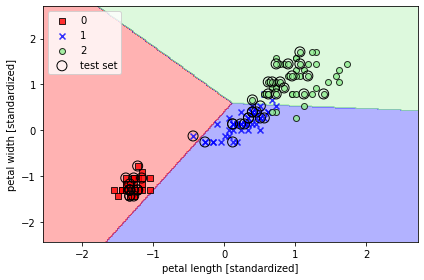

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('images/03_01.png', dpi=300)
plt.show()

<br>
<br>

# 로지스틱 회귀를 사용한 클래스 확률 모델링

...

### 로지스틱 회귀의 이해와 조건부 확률

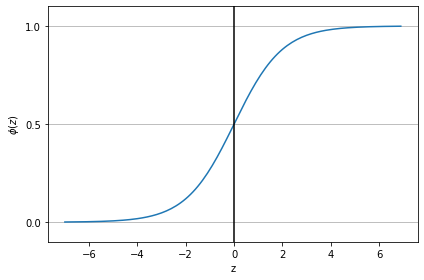

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y 축의 눈금과 격자선
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.savefig('images/03_02.png', dpi=300)
plt.show()

In [3]:
Image(url='https://git.io/Jtm22', width=500) 

<br>
<br>

### 로지스틱 비용 함수의 가중치 학습하기

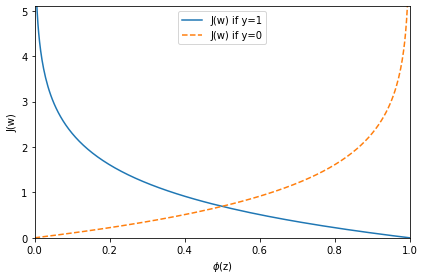

In [14]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('images/03_04.png', dpi=300)
plt.show()

In [15]:
class LogisticRegressionGD(object):
    """경사 하강법을 사용한 로지스틱 회귀 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 로지스틱 비용 함수 값

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # 오차 제곱합 대신 로지스틱 비용을 계산합니다.
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """로지스틱 시그모이드 활성화 계산"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # 다음과 동일합니다.
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

<br>
<br>

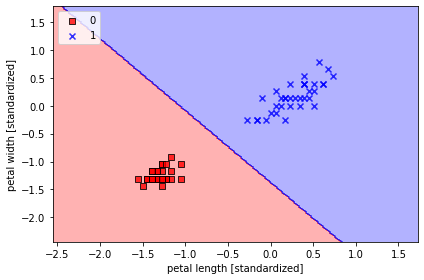

In [16]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('images/03_05.png', dpi=300)
plt.show()

### 사이킷런을 사용해 로지스틱 회귀 모델 훈련하기

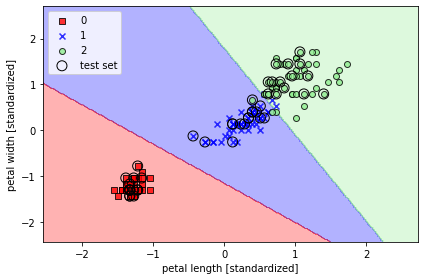

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/03_06.png', dpi=300)
plt.show()

In [18]:
lr.predict_proba(X_test_std[:3, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17]])

In [19]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [20]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [21]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [22]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

<br>
<br>

### 규제를 사용해 과대적합 피하기

In [4]:
Image(url='https://git.io/Jtm2V', width=700) 

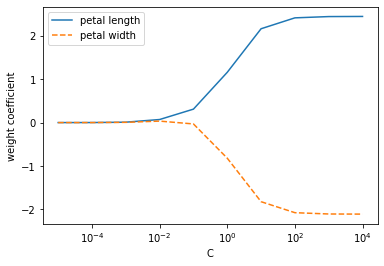

In [24]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.savefig('images/03_08.png', dpi=300)
plt.show()

<br>
<br>

# 서포트 벡터 머신을 사용한 최대 마진 분류

In [5]:
Image(url='https://git.io/Jtm2r', width=700) 

## 최대 마진

...

## 슬랙 변수를 사용하여 비선형 분류 문제 다루기

In [6]:
Image(url='https://git.io/Jtm26', width=600) 

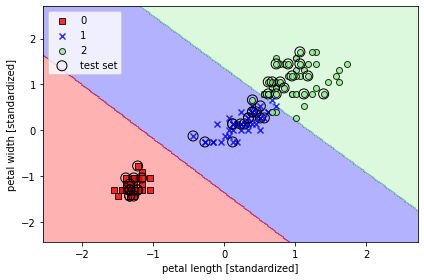

In [27]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/03_11.png', dpi=300)
plt.show()

## 사이킷런의 다른 구현

In [28]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

<br>
<br>

# 커널 SVM을 사용하여 비선형 문제 풀기

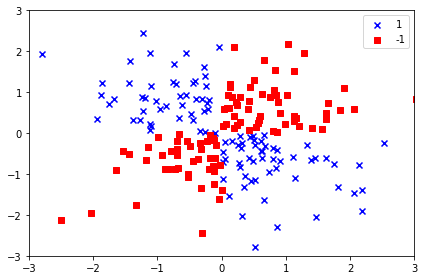

In [29]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('images/03_12.png', dpi=300)
plt.show()

In [7]:
Image(url='https://git.io/Jtm2X', width=700) 

<br>
<br>

## 커널 기법을 사용해 고차원 공간에서 분할 초평면 찾기

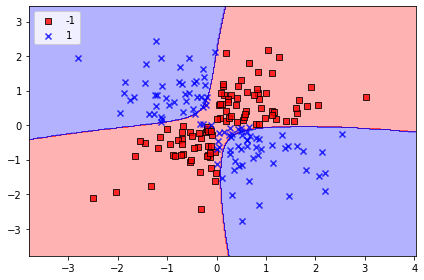

In [31]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/03_14.png', dpi=300)
plt.show()

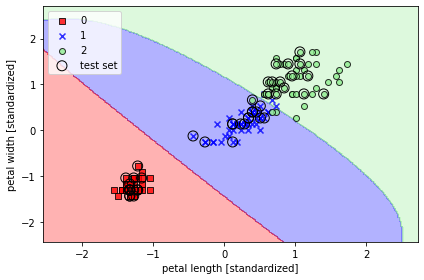

In [32]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/03_15.png', dpi=300)
plt.show()

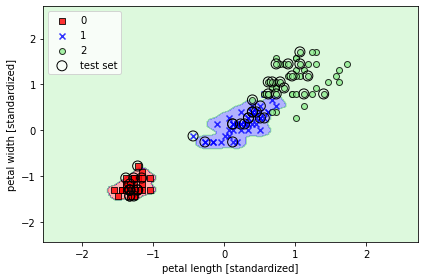

In [33]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/03_16.png', dpi=300)
plt.show()

<br>
<br>

# 결정 트리 학습

In [8]:
Image(url='https://git.io/Jtm21', width=500) 

In [9]:
Image(url='https://git.io/Jtm2D', width=500) 

<br>
<br>

## 정보 이득 최대화 - 자원을 최대로 활용하기

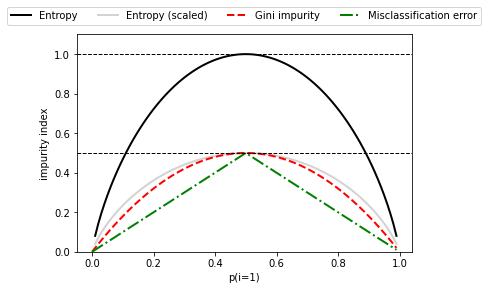

In [36]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

<br>
<br>

## 결정 트리 만들기

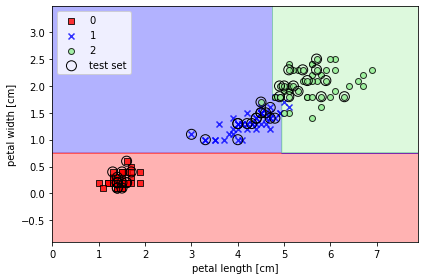

In [37]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/03_20.png', dpi=300)
plt.show()

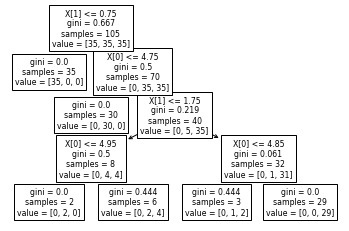

In [38]:
from sklearn import tree

tree.plot_tree(tree_model)
plt.show()

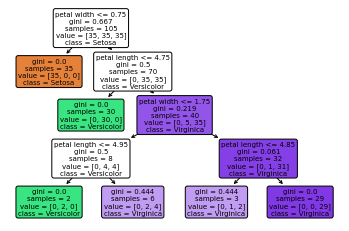

In [39]:
tree.plot_tree(tree_model,
               impurity=True,
               filled=True, 
               rounded=True,
               class_names=['Setosa', 
                            'Versicolor',
                            'Virginica'],
               feature_names=['petal length', 
                              'petal width'])
plt.show()

In [40]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

In [10]:
Image(url='https://git.io/Jtm2H', width=600) 

<br>
<br>

## 랜덤 포레스트로 여러 개의 결정 트리 연결하기

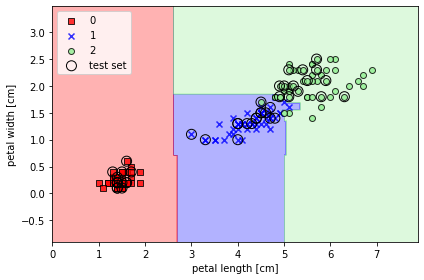

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/03_22.png', dpi=300)
plt.show()

<br>
<br>

# K-최근접 이웃: 게으른 학습 알고리즘

In [11]:
Image(url='https://git.io/Jtm25', width=400) 

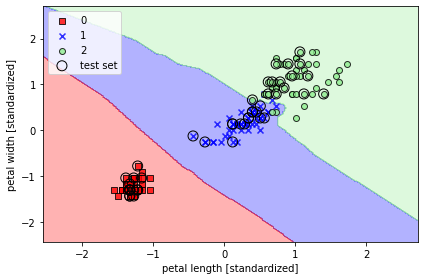

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/03_24.png', dpi=300)
plt.show()

<br>
<br>